<a href="https://colab.research.google.com/github/Milind1505/Wearable-data-anxiety-prediction/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install pandas numpy matplotlib scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Simulate time-series data
np.random.seed(42) # for reproducibility
n_samples = 365 # simulate data for a year

dates = pd.date_range(start='2023-01-01', periods=n_samples, freq='D')
heart_rate = np.random.normal(70, 5, n_samples) + np.sin(np.linspace(0, 4*np.pi, n_samples)) * 3
steps = np.random.normal(8000, 1500, n_samples) + np.cos(np.linspace(0, 6*np.pi, n_samples)) * 1000
sleep_duration = np.random.normal(7.5, 1, n_samples) - np.sin(np.linspace(0, 2*np.pi, n_samples)) * 0.5

# Simulate a target variable (anxiety/depression score)
# This is a simplified simulation for demonstration
anxiety_score = (heart_rate * 0.1 + steps * -0.0005 + sleep_duration * -0.5 + np.random.normal(50, 10, n_samples))

data = pd.DataFrame({
    'date': dates,
    'heart_rate': heart_rate,
    'steps': steps,
    'sleep_duration': sleep_duration,
    'anxiety_score': anxiety_score
})

# Set 'date' as index for time-series analysis
data.set_index('date', inplace=True)

print(data.head())

            heart_rate        steps  sleep_duration  anxiety_score
date                                                              
2023-01-01   72.483571  8398.169292        7.695845      48.394184
2023-01-02   69.412227  9334.798205        6.512997      49.803677
2023-01-03   73.445416  9013.530126        7.890995      28.910272
2023-01-04   77.925301  9134.471046        5.771536      59.502803
2023-01-05   69.242194  7819.108850        8.494660      52.232220


In [3]:
# Basic preprocessing (e.g., handling potential missing values - not applicable to simulated data)
# For real data, you might use data.fillna(method='ffill') or other strategies

# Feature engineering (example: lagged features)
data['heart_rate_lag1'] = data['heart_rate'].shift(1)
data['steps_lag1'] = data['steps'].shift(1)
data['sleep_duration_lag1'] = data['sleep_duration'].shift(1)

# Drop rows with NaN values created by lagging
data.dropna(inplace=True)

print(data.head())

            heart_rate        steps  sleep_duration  anxiety_score  \
date                                                                 
2023-01-02   69.412227  9334.798205        6.512997      49.803677   
2023-01-03   73.445416  9013.530126        7.890995      28.910272   
2023-01-04   77.925301  9134.471046        5.771536      59.502803   
2023-01-05   69.242194  7819.108850        8.494660      52.232220   
2023-01-06   69.344592  9003.431690        7.929497      58.448096   

            heart_rate_lag1   steps_lag1  sleep_duration_lag1  
date                                                           
2023-01-02        72.483571  8398.169292             7.695845  
2023-01-03        69.412227  9334.798205             6.512997  
2023-01-04        73.445416  9013.530126             7.890995  
2023-01-05        77.925301  9134.471046             5.771536  
2023-01-06        69.242194  7819.108850             8.494660  


In [4]:
# Define features (X) and target (y)
features = ['heart_rate', 'steps', 'sleep_duration', 'heart_rate_lag1', 'steps_lag1', 'sleep_duration_lag1']
target = 'anxiety_score'

X = data[features]
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False) # shuffle=False for time-series

# Train a simple model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model (on the test set)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')

Mean Squared Error on Test Set: 108.20600175461762


In [5]:
# Simulate receiving a new data point (e.g., daily aggregated data)
# This would come from a data stream in a real system

# Simulate a new data point after the last date in the training data
last_date_train = X_train.index[-1]
new_date = last_date_train + pd.Timedelta(days=1)

# Simulate new wearable data for the new date
new_heart_rate = np.random.normal(70, 5)
new_steps = np.random.normal(8000, 1500)
new_sleep_duration = np.random.normal(7.5, 1)

# Get lagged features from the last data point in the training set
last_heart_rate = data.loc[last_date_train, 'heart_rate']
last_steps = data.loc[last_date_train, 'steps']
last_sleep_duration = data.loc[last_date_train, 'sleep_duration']

new_data_point = pd.DataFrame({
    'heart_rate': [new_heart_rate],
    'steps': [new_steps],
    'sleep_duration': [new_sleep_duration],
    'heart_rate_lag1': [last_heart_rate],
    'steps_lag1': [last_steps],
    'sleep_duration_lag1': [last_sleep_duration]
}, index=[new_date])

# Make a prediction on the new data point
predicted_anxiety_score = model.predict(new_data_point[features])

print(f'Predicted anxiety score for {new_date.date()}: {predicted_anxiety_score[0]}')

Predicted anxiety score for 2023-09-13: 47.91323703505087


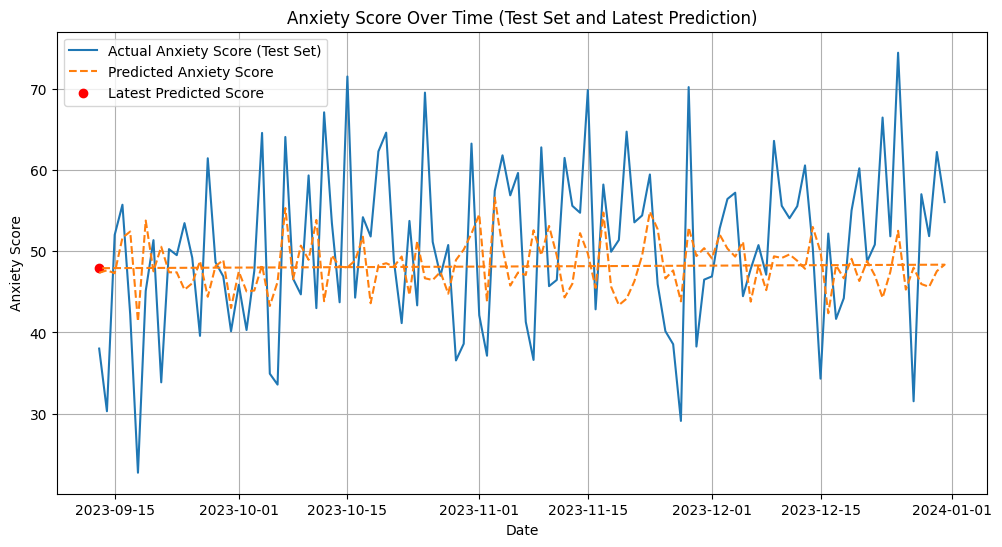

In [6]:
# Combine actual test data and predicted data for visualization
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred}, index=X_test.index)

# Append the latest prediction
latest_prediction_df = pd.DataFrame({
    'actual': [np.nan], # No actual score for the predicted day
    'predicted': predicted_anxiety_score
}, index=[new_date])

results = pd.concat([results, latest_prediction_df])

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['actual'], label='Actual Anxiety Score (Test Set)')
plt.plot(results.index, results['predicted'], label='Predicted Anxiety Score', linestyle='--')
plt.scatter(new_date, predicted_anxiety_score[0], color='red', label='Latest Predicted Score') # Highlight the latest prediction
plt.xlabel('Date')
plt.ylabel('Anxiety Score')
plt.title('Anxiety Score Over Time (Test Set and Latest Prediction)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Install plotly
!pip install plotly

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Combine actual test data and predicted data for visualization
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred}, index=X_test.index)

# Append the latest prediction
latest_prediction_df = pd.DataFrame({
    'actual': [np.nan], # No actual score for the predicted day
    'predicted': predicted_anxiety_score
}, index=[new_date])

results = pd.concat([results, latest_prediction_df])

# Create interactive plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scattergl(x=results.index, y=results['actual'],
                           mode='lines',
                           name='Actual Anxiety Score (Test Set)'))

fig.add_trace(go.Scattergl(x=results.index, y=results['predicted'],
                           mode='lines',
                           name='Predicted Anxiety Score',
                           line=dict(dash='dash')))

fig.add_trace(go.Scattergl(x=[new_date], y=[predicted_anxiety_score[0]],
                           mode='markers',
                           name='Latest Predicted Score',
                           marker=dict(color='red', size=10)))

# Update layout for better appearance
fig.update_layout(
    title='Anxiety Score Over Time (Test Set and Latest Prediction)',
    xaxis_title='Date',
    yaxis_title='Anxiety Score',
    hovermode='x unified' # Shows combined hover info for points on the same x-axis
)

fig.show()

In [9]:
# Install plotly if you haven't already
!pip install plotly
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, clear_output

# Re-combine actual test data and initial predicted data for visualization
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred}, index=X_test.index)

# Create initial interactive plot using Plotly
fig = go.Figure()

actual_trace = go.Scattergl(x=results.index, y=results['actual'],
                           mode='lines',
                           name='Actual Anxiety Score (Test Set)')

predicted_trace = go.Scattergl(x=results.index, y=results['predicted'],
                           mode='lines',
                           name='Predicted Anxiety Score',
                           line=dict(dash='dash'))

latest_prediction_trace = go.Scattergl(x=[], y=[],
                           mode='markers',
                           name='Latest Predicted Score',
                           marker=dict(color='red', size=10))

fig.add_trace(actual_trace)
fig.add_trace(predicted_trace)
fig.add_trace(latest_prediction_trace)

# Update layout for better appearance
fig.update_layout(
    title='Anxiety Score Over Time (Test Set and Simulated Real-Time Predictions)',
    xaxis_title='Date',
    yaxis_title='Anxiety Score',
    hovermode='x unified'
)

# Simulate receiving and predicting on new data points
num_simulated_updates = 5
last_date_processed = X_test.index[-1]

for i in range(num_simulated_updates):
    # Simulate receiving a new data point
    new_date = last_date_processed + pd.Timedelta(days=1)

    # Simulate new wearable data for the new date
    new_heart_rate = np.random.normal(70, 5)
    new_steps = np.random.normal(8000, 1500)
    new_sleep_duration = np.random.normal(7.5, 1)

    # Get lagged features from the last *available* data point
    # This would be the actual data from the previous day in a real system
    if new_date - pd.Timedelta(days=1) in data.index:
         last_heart_rate = data.loc[new_date - pd.Timedelta(days=1), 'heart_rate']
         last_steps = data.loc[new_date - pd.Timedelta(days=1), 'steps']
         last_sleep_duration = data.loc[new_date - pd.Timedelta(days=1), 'sleep_duration']
    else:
        # If the previous day is not in the original data, use the last known values
        # This is a simplification for the simulation
        last_heart_rate = data.iloc[-1]['heart_rate']
        last_steps = data.iloc[-1]['steps']
        last_sleep_duration = data.iloc[-1]['sleep_duration']


    new_data_point = pd.DataFrame({
        'heart_rate': [new_heart_rate],
        'steps': [new_steps],
        'sleep_duration': [new_sleep_duration],
        'heart_rate_lag1': [last_heart_rate],
        'steps_lag1': [last_steps],
        'sleep_duration_lag1': [last_sleep_duration]
    }, index=[new_date])

    # Make a prediction on the new data point
    predicted_anxiety_score = model.predict(new_data_point[features])

    print(f'Simulating prediction for {new_date.date()}: {predicted_anxiety_score[0]:.2f}')

    # Append the new prediction to the results DataFrame
    new_prediction_df = pd.DataFrame({
        'actual': [np.nan], # No actual score for the predicted day
        'predicted': predicted_anxiety_score
    }, index=[new_date])
    results = pd.concat([results, new_prediction_df])

    # Update the Plotly figure with the new prediction
    with fig.batch_update():
        # Update the predicted line
        fig.data[1].x = results.index
        fig.data[1].y = results['predicted']
        # Update the latest prediction marker
        fig.data[2].x = [new_date]
        fig.data[2].y = [predicted_anxiety_score[0]]

    # Clear the previous output and display the updated figure
    clear_output(wait=True)
    display(fig)

    # Pause briefly to simulate time passing
    time.sleep(1)

    last_date_processed = new_date

print("Simulated real-time updates finished.")

Simulated real-time updates finished.


In [17]:
# Install necessary libraries
!pip install pandas numpy matplotlib scikit-learn tensorflow transformers prophet

# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib # To save/load models later

# Import TensorFlow/Keras specific libraries for LSTM/Transformers
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, MultiHeadAttention, LayerNormalization, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Import Prophet
from prophet import Prophet

import transformers
from transformers import TFBertModel, BertConfig # Uncomment if you are using actual BERT

In [18]:
# Simulate time-series data
np.random.seed(42) # for reproducibility
n_samples = 365 # simulate data for a year

dates = pd.date_range(start='2023-01-01', periods=n_samples, freq='D')
heart_rate = np.random.normal(70, 5, n_samples) + np.sin(np.linspace(0, 4*np.pi, n_samples)) * 3
steps = np.random.normal(8000, 1500, n_samples) + np.cos(np.linspace(0, 6*np.pi, n_samples)) * 1000
sleep_duration = np.random.normal(7.5, 1, n_samples) - np.sin(np.linspace(0, 2*np.pi, n_samples)) * 0.5

# Simulate a target variable (anxiety/depression score)
anxiety_score = (heart_rate * 0.1 + steps * -0.0005 + sleep_duration * -0.5 + np.random.normal(50, 10, n_samples))

data = pd.DataFrame({
    'date': dates,
    'heart_rate': heart_rate,
    'steps': steps,
    'sleep_duration': sleep_duration,
    'anxiety_score': anxiety_score
})

# Set 'date' as index for time-series analysis
data.set_index('date', inplace=True)

print(data.head())

            heart_rate        steps  sleep_duration  anxiety_score
date                                                              
2023-01-01   72.483571  8398.169292        7.695845      48.394184
2023-01-02   69.412227  9334.798205        6.512997      49.803677
2023-01-03   73.445416  9013.530126        7.890995      28.910272
2023-01-04   77.925301  9134.471046        5.771536      59.502803
2023-01-05   69.242194  7819.108850        8.494660      52.232220


In [19]:
# Basic preprocessing (Handling potential missing values - not applicable to simulated data)
# For real data, you might use data.fillna(method='ffill') or other strategies

# Feature engineering (Lagged features are still useful, but sequence matters more for RNNs/Transformers)
# We'll keep them for consistency, but the core data will be sequences of raw features
data['heart_rate_lag1'] = data['heart_rate'].shift(1)
data['steps_lag1'] = data['steps'].shift(1)
data['sleep_duration_lag1'] = data['sleep_duration'].shift(1)

# Drop rows with NaN values created by lagging
data.dropna(inplace=True)

# --- Prepare data for sequential models (LSTM, Transformer) ---
# We need to create input sequences and corresponding target values

def create_sequences(data, lookback_window):
    """
    Creates sequences of data for time-series models.

    Args:
        data: pandas DataFrame or numpy array containing the time-series data.
        lookback_window: The number of past time steps to include in each sequence.

    Returns:
        X: numpy array of sequences (samples, lookback_window, features).
        y: numpy array of target values (samples,).
    """
    X, y = [], []
    for i in range(len(data) - lookback_window):
        # Get the sequence of features
        seq_x = data.iloc[i:(i + lookback_window)]
        # Get the target value at the next time step
        seq_y = data.iloc[i + lookback_window]['anxiety_score'] # Assuming 'anxiety_score' is the target

        X.append(seq_x.values) # Append numpy array of the sequence
        y.append(seq_y)

    return np.array(X), np.array(y)

# Define features and target
features = ['heart_rate', 'steps', 'sleep_duration', 'heart_rate_lag1', 'steps_lag1', 'sleep_duration_lag1']
target = 'anxiety_score'

# Separate features and target for sequence creation
feature_data = data[features]
target_data = data[target]

lookback_window = 10 # Example: use the past 10 days to predict the next day

# Create sequences
X_sequences, y_sequences = create_sequences(data, lookback_window)

# Split the sequence data (maintain temporal order)
train_size_seq = int(len(X_sequences) * 0.7) # 70% for training
X_train_seq, X_test_seq = X_sequences[:train_size_seq], X_sequences[train_size_seq:]
y_train_seq, y_test_seq = y_sequences[:train_size_seq], y_sequences[train_size_seq:]

print(f"Original data shape: {data.shape}")
print(f"Sequence data shape (X): {X_sequences.shape}")
print(f"Sequence data shape (y): {y_sequences.shape}")
print(f"Training sequence data shape (X_train_seq): {X_train_seq.shape}")
print(f"Testing sequence data shape (X_test_seq): {X_test_seq.shape}")

# --- Prepare data for ARIMA/Prophet ---
# ARIMA and Prophet typically work with a single time series and its timestamp
# They don't directly handle multiple exogenous variables as sequences in the same way
# For this example, we'll focus on predicting the 'anxiety_score' directly using ARIMA/Prophet

# Create a simple DataFrame for ARIMA/Prophet with just date and target
# Prophet requires columns named 'ds' (datestamp) and 'y' (value)
prophet_data = data.reset_index()[['date', 'anxiety_score']].rename(columns={'date': 'ds', 'anxiety_score': 'y'})

# Split data for ARIMA/Prophet (maintain temporal order)
train_size_ts = int(len(prophet_data) * 0.7) # 70% for training
prophet_train_data = prophet_data.iloc[:train_size_ts]
prophet_test_data = prophet_data.iloc[train_size_ts:] # Keep for comparison

print(f"Prophet training data shape: {prophet_train_data.shape}")

Original data shape: (364, 7)
Sequence data shape (X): (354, 10, 7)
Sequence data shape (y): (354,)
Training sequence data shape (X_train_seq): (247, 10, 7)
Testing sequence data shape (X_test_seq): (107, 10, 7)
Prophet training data shape: (254, 2)


In [20]:
# --- Build and Train LSTM Model ---

# Define the LSTM model architecture
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1) # Output layer for regression
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Build the model
lstm_input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
lstm_model = build_lstm_model(lstm_input_shape)
lstm_model.summary()

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
print("\nTraining LSTM model...")
history_lstm = lstm_model.fit(X_train_seq, y_train_seq,
                              epochs=100, # You might need more epochs
                              batch_size=32,
                              validation_split=0.2, # Use a validation split from the training data
                              callbacks=[early_stopping],
                              verbose=1)

# Evaluate the LSTM model on the test set
lstm_loss = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f'LSTM Mean Squared Error on Test Set: {lstm_loss}')

# Make predictions with LSTM
y_pred_lstm = lstm_model.predict(X_test_seq).flatten() # Flatten predictions if they are nested arrays

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,851 (124.42 KB)

 Trainable params: 31,851 (124.42 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 2616.7866 - val_loss: 2299.6553
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2549.5969 - val_loss: 2168.8044
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2421.4775 - val_loss: 2033.9598
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2265.2417 - val_loss: 1918.4619
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2175.4900 - val_loss: 1816.9078
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2025.9927 - val_loss: 1724.1204
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1936.2971 - val_loss: 1643.4983
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1788.6472 - val_loss: 1581.3328
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1816.4280 - val_loss: 1531.4329
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1702.7662 - val_loss: 1489.6484
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1700.1248 - va

In [23]:
# --- Build a Simplified Transformer Model for Time Series ---

# Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training): # Ensure 'training' is accepted here
        attn_output = self.att(inputs, inputs)
        # Pass the training argument to dropout layers
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        # Pass the training argument to dropout layers
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Token and Position Embedding (Illustrative for sequential data)
# In a real time series transformer, you might have different embedding strategies
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # Here, vocab_size would be the number of features if you treat features as tokens
        # Or you might use embedding on normalized feature values
        self.token_emb = Dense(embed_dim) # Using a Dense layer to project features to embed_dim
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Define the Transformer model architecture
def build_transformer_model(input_shape, embed_dim, num_heads, ff_dim, num_transformer_blocks):
    inputs = Input(shape=input_shape)
    # Embedding layer (adapting for numerical time series data)
    # This part needs careful consideration based on your feature types
    x = Dense(embed_dim)(inputs) # Simple dense layer to map features to embedding dimension

    # Add positional encoding (essential for Transformers)
    maxlen = input_shape[0]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = Embedding(input_dim=maxlen, output_dim=embed_dim)(positions)
    x = x + positions

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        # Explicitly pass training=None when calling the custom TransformerBlock
        # Keras will handle this automatically during fit/predict/evaluate
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=None)

    # Global pooling and dense layers for regression
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x, training=None) # Also pass training to dropout layers if called directly
    outputs = Dense(1)(x) # Regression output

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Define parameters for the Transformer model
embed_dim = 32  # Embedding size for features
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feedforward network inside transformer block
num_transformer_blocks = 2 # Number of transformer blocks

# Build the Transformer model
transformer_input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
transformer_model = build_transformer_model(transformer_input_shape, embed_dim, num_heads, ff_dim, num_transformer_blocks)
transformer_model.summary()

# Train the Transformer model (requires reshaping y_train_seq if not already)
# Define early stopping
early_stopping_transformer = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nTraining Transformer model...")
history_transformer = transformer_model.fit(X_train_seq, y_train_seq,
                                           epochs=100, # You might need more epochs
                                           batch_size=32,
                                           validation_split=0.2, # Use a validation split from the training data
                                           callbacks=[early_stopping_transformer],
                                           verbose=1)

# Evaluate the Transformer model on the test set
transformer_loss = transformer_model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f'Transformer Mean Squared Error on Test Set: {transformer_loss}')

# Make predictions with Transformer
y_pred_transformer = transformer_model.predict(X_test_seq).flatten() # Flatten predictions if they are nested arrays

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10, 32)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_2 (Add)                     │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 10, 32)         │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, 10, 32)         │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,601 (84.38 KB)

 Trainable params: 21,601 (84.38 KB)

 Non-trainable params: 0 (0.00 B)


Training Transformer model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 2713.5564 - val_loss: 2089.4912
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2235.9636 - val_loss: 1817.4343
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2001.4811 - val_loss: 1699.2312
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1874.3015 - val_loss: 1655.7935
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1862.7303 - val_loss: 1625.2137
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1852.3453 - val_loss: 1596.8499
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1806.3846 - val_loss: 1570.2184
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1870.6509 - val_loss: 1543.7550
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1743.7185 - val_loss: 1517.0253
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1700.6134 - val_loss: 1490.1207
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1714.74

In [24]:
# --- Build and Train ARIMA Model ---

# ARIMA is not directly available in scikit-learn, commonly used libraries are `statsmodels` or `pmdarima`

# We'll use a simplified ARIMA example from statsmodels
# !pip install statsmodels

from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore") # Ignore warnings from ARIMA

# Define the order of the ARIMA model (p, d, q)
# p: order of the autoregressive part
# d: degree of differencing
# q: order of the moving average part
# Choosing the right order is crucial and often involves analyzing ACF/PACF plots
arima_order = (5, 1, 0) # Example order (ARIMA(5,1,0) is an AR(5) model on differenced data)

print("\nTraining ARIMA model...")
# Fit the ARIMA model on the training data (prophet_train_data['y'])
# ARIMA works best on stationary data, differencing (d > 0) helps with trends
arima_model = ARIMA(prophet_train_data['y'], order=arima_order)
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

# Make predictions with ARIMA
# Predict on the test set
# The number of steps to forecast is the length of the test set
n_forecast = len(prophet_test_data)
arima_predictions = arima_model_fit.forecast(steps=n_forecast)

# Evaluate the ARIMA model
# We need to compare the predictions to the actual values in the test set
arima_mse = mean_squared_error(prophet_test_data['y'], arima_predictions)
print(f'ARIMA Mean Squared Error on Test Set: {arima_mse}')


Training ARIMA model...
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  254
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -966.276
Date:                Thu, 22 May 2025   AIC                           1944.552
Time:                        06:40:55   BIC                           1965.753
Sample:                             0   HQIC                          1953.082
                                - 254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8554      0.057    -14.895      0.000      -0.968      -0.743
ar.L2         -0.6710      0.080     -8.391      0.000      -0.828      -0.514
ar.L3         -0.4295      

In [25]:
# --- Build and Train Prophet Model ---

# Prophet requires a DataFrame with columns 'ds' (datestamp) and 'y' (value)
# We already prepared 'prophet_train_data' in Cell 3

print("\nTraining Prophet model...")
# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_train_data)

# Create a DataFrame with future dates to forecast
# We need to forecast for the same number of steps as our test set
future = prophet_model.make_future_dataframe(periods=len(prophet_test_data))

# Make predictions
prophet_forecast = prophet_model.predict(future)

# Extract the predicted values corresponding to the test set dates
# Merge the forecast with the actual test data to align predictions
prophet_predictions = prophet_forecast[['ds', 'yhat']].tail(len(prophet_test_data))
# Ensure the dates match
prophet_predictions = prophet_predictions.set_index('ds').reindex(prophet_test_data['ds']).reset_index()


# Evaluate the Prophet model
prophet_mse = mean_squared_error(prophet_test_data['y'], prophet_predictions['yhat'])
print(f'Prophet Mean Squared Error on Test Set: {prophet_mse}')

# Prophet also provides components plots
# fig1 = prophet_model.plot(prophet_forecast)
# fig2 = prophet_model.plot_components(prophet_forecast)


Training Prophet model...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67933jq3/nm1v7kgt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67933jq3/c6ms8gh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26648', 'data', 'file=/tmp/tmp67933jq3/nm1v7kgt.json', 'init=/tmp/tmp67933jq3/c6ms8gh7.json', 'output', 'file=/tmp/tmp67933jq3/prophet_model5mmdrcrp/prophet_model-20250522064109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:41:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:41:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Mean Squared Error on Test Set: 116.66196845497095



--- Model Performance Comparison (MSE on Test Set) ---
Random Forest Regressor: 108.2060
LSTM: 296.7753
Transformer (Simplified): 107.1467
ARIMA: 164.7183
Prophet: 116.6620


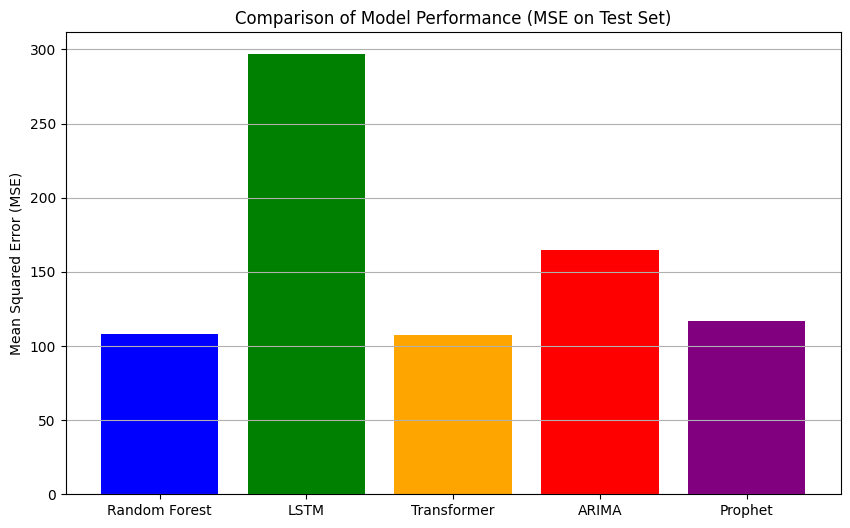

In [26]:
# Assume the following MSE values were obtained from running the previous model training cells:
# mse (from RandomForestRegressor)
# lstm_loss (from LSTM)
# transformer_loss (from Transformer)
# arima_mse (from ARIMA)
# prophet_mse (from Prophet)

print("\n--- Model Performance Comparison (MSE on Test Set) ---")
print(f"Random Forest Regressor: {mse:.4f}")
print(f"LSTM: {lstm_loss:.4f}")
print(f"Transformer (Simplified): {transformer_loss:.4f}")
print(f"ARIMA: {arima_mse:.4f}")
print(f"Prophet: {prophet_mse:.4f}")

# You can also create a simple bar plot for visual comparison
model_names = ['Random Forest', 'LSTM', 'Transformer', 'ARIMA', 'Prophet']
mse_values = [mse, lstm_loss, transformer_loss, arima_mse, prophet_mse]

plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_values, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Model Performance (MSE on Test Set)')
plt.grid(axis='y')
plt.show()

In [28]:
# Install Keras Tuner
!pip install keras-tuner

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split # Import train_test_split

# --- Define a model building function for Keras Tuner ---
def build_lstm_model_for_tuning(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
                   return_sequences=True,
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # Add a second LSTM layer with a probability
    # Check if we want a second LSTM layer based on the hyperparameter search
    if hp.Boolean("two_lstm_layers"):
         model.add(LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)))
         model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    else:
        # If not two layers, still add a second LSTM but maybe don't tune its units explicitly in this branch
        # A more robust way might be to always have two, but allow the units of the second to be tuned
        # Let's simplify and ensure the first LSTM always has return_sequences=True and the second doesn't
        # The original code had return_sequences=True on the first and False (default) on the second, which is correct
        # Let's fix the 'else' branch to simply not have a second LSTM, or handle it differently.
        # A simpler fix is to keep the structure and just tune the params. The boolean controls adding the layer itself.
         # Original code seems to add a second LSTM regardless, just tuning its size if 'two_lstm_layers' is True.
         # Let's align with the apparent intent, ensuring the first returns sequences and the second doesn't by default.
         pass # Remove the redundant LSTM add in the else branch. The Boolean condition is sufficient.


    # The LSTM setup should be first LSTM with return_sequences=True, second with default (False)
    # Let's restructure slightly to ensure this.
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
                   return_sequences=True, # First LSTM returns sequences
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # Add the second LSTM layer if the boolean hyperparameter is true
    if hp.Boolean("two_lstm_layers"):
         model.add(LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32),
                        return_sequences=False)) # Second LSTM does NOT return sequences before Dense
         model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    else:
        # If only one LSTM layer, ensure the first one does not return sequences if it's the last sequence layer
        # However, the original intent seems to be at least one LSTM feeding into a Dropout and then Dense.
        # Let's adjust the logic: always have at least one LSTM, and potentially a second.
        # The structure should be: Input -> LSTM (return_sequences=True) -> Dropout -> [Optional LSTM (return_sequences=False) -> Dropout] -> Dense

        # Let's stick to the original logic where the boolean controls adding a SECOND LSTM.
        # The first LSTM *must* return sequences if a second LSTM follows. If only one LSTM, it shouldn't return sequences.
        # This requires a slightly different logic in the build function.

        # Let's simplify the build function to always have the two-layer structure but tune the sizes and dropouts.
        # The boolean can control *whether* the second layer exists, or other aspects.
        # Given the initial structure, let's assume the intent is a potential two-layer stack.
        # The boolean `two_lstm_layers` seems intended to add a second LSTM layer *on top* of the first.
        # So, the first LSTM should always return sequences if the second one exists.

        # Corrected Logic:
        # Always add the first LSTM layer, returning sequences
        # Optionally add the second LSTM layer based on the boolean, this second layer does NOT return sequences.
        # If the second layer is NOT added, the first layer should then *not* return sequences (as it's the last sequence layer before Dense).

        model = Sequential()
        model.add(LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
                       return_sequences=hp.Boolean("two_lstm_layers"), # Return sequences only if there's a second layer
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

        if hp.Boolean("two_lstm_layers"):
             model.add(LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32))) # Default return_sequences=False
             model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))


    model.add(Dense(units=1))

    # Tune the learning rate of the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# --- Split the data into training and validation sets for Keras Tuner ---
# Use a small portion of the original training data for validation during tuning
X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, shuffle=False, # shuffle=False for time-series
    random_state=42 # for reproducibility
)

print(f"Tuning Train sequence data shape (X_train_tune): {X_train_tune.shape}")
print(f"Tuning Validation sequence data shape (X_val_tune): {X_val_tune.shape}")


# --- Initialize the Tuner ---
# Using RandomSearch as an example
tuner = kt.RandomSearch(
    build_lstm_model_for_tuning,
    objective='val_loss', # Objective is to minimize validation loss
    max_trials=10,       # Number of different hyperparameter combinations to try
    executions_per_trial=1, # Reduced executions per trial to speed up tuning for demonstration
    directory='keras_tuner_dir', # Directory to store results
    project_name='lstm_anxiety_tuning_v2') # Use a new project name

# --- Define Early Stopping for tuning ---
# Use Early Stopping to stop training trials if val_loss doesn't improve
early_stopping_tuning = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


print("\nStarting Hyperparameter Tuning...")
# --- Run the tuner ---
# Pass the dedicated training and validation sets
tuner.search(X_train_tune, y_train_tune,
             epochs=50, # Max epochs for each trial (Early Stopping will stop earlier)
             batch_size=32,
             validation_data=(X_val_tune, y_val_tune), # Pass validation data explicitly
             callbacks=[early_stopping_tuning])

# --- Get the best hyperparameters and the best model ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("\n--- Best Hyperparameters Found ---")
print(best_hps.values)

print("\n--- Best Model Summary ---")
best_model.summary()

# Evaluate the best model on the test set (X_test_seq, y_test_seq)
best_model_loss = best_model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f'Best Tuned LSTM Mean Squared Error on Test Set: {best_model_loss}')

Trial 10 Complete [00h 00m 11s]
val_loss: 84.9242935180664

Best val_loss So Far: 84.79959869384766
Total elapsed time: 00h 02m 59s

--- Best Hyperparameters Found ---
{'lstm_units_1': 128, 'dropout_1': 0.0, 'two_lstm_layers': False, 'learning_rate': 0.01}

--- Best Model Summary ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,761 (272.50 KB)

 Trainable params: 69,761 (272.50 KB)

 Non-trainable params: 0 (0.00 B)

Best Tuned LSTM Mean Squared Error on Test Set: 106.14247131347656


In [30]:
# Illustrative code snippet (Requires scikit-learn)
# from sklearn.model_selection import TimeSeriesSplit # scikit-learn has TimeSeriesSplit

# Assume you have your full time-series data 'data'

# --- Time Series Split (Illustrative) ---
# Not directly using TimeSeriesSplit here as we need to handle sequences

def time_series_cv_evaluation(model_builder, data, lookback_window, n_splits=5):
    """
    Performs time series cross-validation and evaluates the model.

    Args:
        model_builder: A function that builds and compiles the model
                       (e.g., build_lstm_model).
        data: The full preprocessed DataFrame (including the target).
        lookback_window: The lookback window size for sequences.
        n_splits: The number of splits for cross-validation.

    Returns:
        A list of evaluation scores (e.g., MSE) for each split.
    """
    mse_scores = []
    total_samples = len(data)
    fold_size = total_samples // (n_splits + lookback_window) # Approximate size of each fold

    for i in range(n_splits):
        # Determine the split points (maintain temporal order)
        train_end_index = i * fold_size + lookback_window
        test_start_index = train_end_index
        test_end_index = test_start_index + fold_size

        if test_end_index > total_samples:
             test_end_index = total_samples

        # Ensure there's enough data for both train and test in this split
        if train_end_index >= test_end_index:
            print(f"Skipping split {i}: Insufficient data.")
            continue

        # Create sequences for the current split
        fold_data = data.iloc[test_start_index - lookback_window:test_end_index]
        if len(fold_data) < lookback_window + 1:
             print(f"Skipping split {i}: Not enough data for sequences.")
             continue

        X_fold_sequences, y_fold_sequences = create_sequences(fold_data, lookback_window)

        # Split sequences into train and test for this fold
        fold_train_size = len(data.iloc[:test_start_index - lookback_window]) - lookback_window # Number of training sequences before this test fold
        if fold_train_size <= 0:
             print(f"Skipping split {i}: Not enough historical data for training sequences.")
             continue

        X_train_fold = X_sequences[:fold_train_size]
        y_train_fold = y_sequences[:fold_train_size]

        X_test_fold = X_fold_sequences
        y_test_fold = y_fold_sequences


        # Ensure train and test sets for the fold are not empty
        if X_train_fold.shape[0] == 0 or X_test_fold.shape[0] == 0:
             print(f"Skipping split {i}: Empty train or test set.")
             continue

        print(f"\nProcessing Split {i+1}/{n_splits}")
        print(f"Train sequences shape: {X_train_fold.shape}")
        print(f"Test sequences shape: {X_test_fold.shape}")


        # Build and train a new instance of the model for each fold
        model = model_builder((X_train_fold.shape[1], X_train_fold.shape[2]))

        # Use a basic early stopping for CV folds
        fold_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        print("Training model for fold...")
        history = model.fit(X_train_fold, y_train_fold,
                            epochs=50, # Limit epochs for CV folds
                            batch_size=32,
                            validation_split=0.2, # Use validation split within the training data
                            callbacks=[fold_early_stopping],
                            verbose=0) # Suppress verbose output during CV

        # Evaluate the model on the test set for this fold
        print("Evaluating model on fold test set...")
        fold_loss = model.evaluate(X_test_fold, y_test_fold, verbose=0)
        mse_scores.append(fold_loss)
        print(f"Fold {i+1} MSE: {fold_loss:.4f}")


    return mse_scores

# --- Example Usage (assuming build_lstm_model and data are available) ---
cv_scores = time_series_cv_evaluation(build_lstm_model, data, lookback_window, n_splits=5)
print("\n--- Time Series Cross-Validation Results (MSE) ---")
print(f"Individual Fold MSEs: {cv_scores}")
print(f"Mean CV MSE: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of CV MSEs: {np.std(cv_scores):.4f}")

Skipping split 0: Not enough historical data for training sequences.

Processing Split 2/5
Train sequences shape: (14, 10, 7)
Test sequences shape: (24, 10, 7)
Training model for fold...
Evaluating model on fold test set...
Fold 2 MSE: 1749.5006

Processing Split 3/5
Train sequences shape: (38, 10, 7)
Test sequences shape: (24, 10, 7)
Training model for fold...
Evaluating model on fold test set...
Fold 3 MSE: 2019.9545

Processing Split 4/5
Train sequences shape: (62, 10, 7)
Test sequences shape: (24, 10, 7)
Training model for fold...
Evaluating model on fold test set...
Fold 4 MSE: 1364.2285

Processing Split 5/5
Train sequences shape: (86, 10, 7)
Test sequences shape: (24, 10, 7)
Training model for fold...
Evaluating model on fold test set...
Fold 5 MSE: 1069.2306

--- Time Series Cross-Validation Results (MSE) ---
Individual Fold MSEs: [1749.5006103515625, 2019.9544677734375, 1364.228515625, 1069.2305908203125]
Mean CV MSE: 1550.7285
Standard Deviation of CV MSEs: 362.7347


In [34]:
# Create sequences with the expanded feature set
# Pass the full data DataFrame to create_sequences so it can access the target column
X_sequences_new, y_sequences_new = create_sequences(data, lookback_window)

# Split the new sequence data into training and testing sets (maintain temporal order)
train_size_seq_new = int(len(X_sequences_new) * 0.7) # Using 70/30 split
X_train_seq_new, X_test_seq_new = X_sequences_new[:train_size_seq_new], X_sequences_new[train_size_seq_new:]
y_train_seq_new, y_test_seq_new = y_sequences_new[:train_size_seq_new], y_sequences_new[train_size_seq_new:]

print(f"\nData shape with additional features: {data.shape}")
print(f"New Sequence data shape (X_sequences_new): {X_sequences_new.shape}")
print(f"New Sequence data shape (y_sequences_new): {y_sequences_new.shape}")
print(f"New Training sequence data shape (X_train_seq_new): {X_train_seq_new.shape}")
print(f"New Testing sequence data shape (X_test_seq_new): {X_test_seq_new.shape}")

# After creating the sequences, you then select the desired features for X_sequences_new
# based on your 'features_with_more' list.

# Corrected approach: Create sequences from the full data, then filter features
X_sequences_full, y_sequences_new = create_sequences(data, lookback_window)

# Now, filter X_sequences_full to only include the desired features from features_with_more
# We need the column indices of the features in features_with_more within the data DataFrame.
# The create_sequences function returns X with shape (samples, lookback_window, all_data_columns)
# We need to select columns corresponding to features_with_more from the last dimension.

# Get the list of all columns in the DataFrame used to create sequences
all_data_columns = data.columns.tolist()

# Get the indices of the features_with_more columns within all_data_columns
feature_indices = [all_data_columns.index(feature) for feature in features_with_more]

# Select only the desired feature columns from the X sequences
X_sequences_new = X_sequences_full[:, :, feature_indices]


# Split the new sequence data into training and testing sets (maintain temporal order)
train_size_seq_new = int(len(X_sequences_new) * 0.7) # Using 70/30 split
X_train_seq_new, X_test_seq_new = X_sequences_new[:train_size_seq_new], X_sequences_new[train_size_seq_new:]
y_train_seq_new, y_test_seq_new = y_sequences_new[:train_size_seq_new], y_sequences_new[train_size_seq_new:]

print(f"\nData shape with additional features: {data.shape}")
print(f"New Sequence data shape (X_sequences_new): {X_sequences_new.shape}")
print(f"New Sequence data shape (y_sequences_new): {y_sequences_new.shape}")
print(f"New Training sequence data shape (X_train_seq_new): {X_train_seq_new.shape}")
print(f"New Testing sequence data shape (X_test_seq_new): {X_test_seq_new.shape}")


Data shape with additional features: (358, 10)
New Sequence data shape (X_sequences_new): (348, 10, 10)
New Sequence data shape (y_sequences_new): (348,)
New Training sequence data shape (X_train_seq_new): (243, 10, 10)
New Testing sequence data shape (X_test_seq_new): (105, 10, 10)

Data shape with additional features: (358, 10)
New Sequence data shape (X_sequences_new): (348, 10, 9)
New Sequence data shape (y_sequences_new): (348,)
New Training sequence data shape (X_train_seq_new): (243, 10, 9)
New Testing sequence data shape (X_test_seq_new): (105, 10, 9)


In [35]:
# --- Train and Evaluate LSTM Model with New Features ---

# Adjust the input shape for the new number of features
lstm_input_shape_new = (X_train_seq_new.shape[1], X_train_seq_new.shape[2])
lstm_model_new = build_lstm_model(lstm_input_shape_new) # Assuming build_lstm_model is defined

# Define early stopping
early_stopping_new_lstm = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nTraining LSTM model with new features...")
history_lstm_new = lstm_model_new.fit(X_train_seq_new, y_train_seq_new,
                                     epochs=100, # You might need more epochs
                                     batch_size=32,
                                     validation_split=0.2,
                                     callbacks=[early_stopping_new_lstm],
                                     verbose=1)

# Evaluate the new LSTM model
lstm_loss_new = lstm_model_new.evaluate(X_test_seq_new, y_test_seq_new, verbose=0)
print(f'LSTM Mean Squared Error on Test Set (with new features): {lstm_loss_new}')

# Make predictions with the new LSTM model
y_pred_lstm_new = lstm_model_new.predict(X_test_seq_new).flatten()

# --- Train and Evaluate Transformer Model with New Features ---

# Adjust the input shape for the new number of features
transformer_input_shape_new = (X_train_seq_new.shape[1], X_train_seq_new.shape[2])
transformer_model_new = build_transformer_model(transformer_input_shape_new, embed_dim, num_heads, ff_dim, num_transformer_blocks) # Assuming build_transformer_model is defined

# Define early stopping
early_stopping_new_transformer = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nTraining Transformer model with new features...")
history_transformer_new = transformer_model_new.fit(X_train_seq_new, y_train_seq_new,
                                                    epochs=100, # You might need more epochs
                                                    batch_size=32,
                                                    validation_split=0.2,
                                                    callbacks=[early_stopping_new_transformer],
                                                    verbose=1)

# Evaluate the new Transformer model
transformer_loss_new = transformer_model_new.evaluate(X_test_seq_new, y_test_seq_new, verbose=0)
print(f'Transformer Mean Squared Error on Test Set (with new features): {transformer_loss_new}')

# Make predictions with the new Transformer model
y_pred_transformer_new = transformer_model_new.predict(X_test_seq_new).flatten()

# --- Compare MSE with and without new features ---
print("\n--- Model Performance Comparison (MSE on Test Set) ---")
print(f"LSTM (Original Features): {lstm_loss:.4f}")
print(f"LSTM (New Features): {lstm_loss_new:.4f}")
print(f"Transformer (Original Features): {transformer_loss:.4f}")
print(f"Transformer (New Features): {transformer_loss_new:.4f}")

# You can add other models here if you train them with new features (e.g., ARIMAX, Prophet with regressors)


Training LSTM model with new features...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 2562.2046 - val_loss: 2231.4087
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2469.7280 - val_loss: 2074.9927
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2281.7854 - val_loss: 1920.3877
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2132.2695 - val_loss: 1788.1993
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1948.8940 - val_loss: 1673.1505
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1881.1833 - val_loss: 1578.8782
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1799.6962 - val_loss: 1504.8501
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1643.8982 - val_loss: 1446.4824
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1632.1038 - val_loss: 1398.0291
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1585.8232 - val_loss: 1356.7028
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - los

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step

Training Transformer model with new features...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 2310.3374 - val_loss: 1876.3730
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2077.9077 - val_loss: 1811.6443
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1996.5375 - val_loss: 1781.4445
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2029.3619 - val_loss: 1754.4636
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1955.2036 - val_loss: 1729.4926
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1885.7734 - val_loss: 1704.2451
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1971.0969 - val_loss: 1678.4517
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1840.8795 - val_loss: 1652.1920
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1805.7482 - val_loss: 1625.2283
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1866.0940 - val_loss: 1597.3094
Epoch 11/1

In [36]:
# Assuming you have already trained your model (e.g., RandomForestRegressor)
# and it's stored in the 'model' variable.

import joblib

# Save the trained model
joblib.dump(model, 'anxiety_model.pkl')

print("Model saved as anxiety_model.pkl")

Model saved as anxiety_model.pkl


In [40]:
!pip install streamlit
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import os

# Set page title and layout
st.set_page_config(page_title="Anxiety Prediction Demo", layout="wide")

st.title("Wearable Data Anxiety Prediction Demo")
st.write("This is a simplified demonstration using a pre-trained model.")

# --- Load the trained model ---
# Assume the model file 'anxiety_model.pkl' is uploaded to the Space
model_path = "anxiety_model.pkl"

try:
    model = joblib.load(model_path)
    st.success("Model loaded successfully!")
except FileNotFoundError:
    st.error(f"Model file not found at {model_path}. Please ensure it is uploaded.")
    model = None
except Exception as e:
    st.error(f"Error loading model: {e}")
    model = None

# --- Define the features the model expects ---
# Ensure this matches the features used during training
model_features = [
    'heart_rate',
    'steps',
    'sleep_duration',
    'heart_rate_lag1',
    'steps_lag1',
    'sleep_duration_lag1'
    # Add any other features your trained model expects
]

# --- Data Input (Simulated or User Input) ---

st.header("Simulated Wearable Data for Prediction")

# You can allow users to input data or use a simulated example
simulate_data = st.checkbox("Use Simulated Data", value=True)

if simulate_data:
    st.write("Using a simulated data point for demonstration.")
    # Simulate values for the latest day
    latest_heart_rate = np.random.normal(70, 5)
    latest_steps = np.random.normal(8000, 1500)
    latest_sleep_duration = np.random.normal(7.5, 1)

    # To get realistic lagged features in a demo, you'd need previous day's data.
    # For this simple demo, let's just simulate lagged values too, or set them based on the latest.
    # In a real system, this would come from your database.
    # A simple approach for demo: assume yesterday's values were similar to today's
    yesterday_heart_rate = np.random.normal(70, 5) # Simplification
    yesterday_steps = np.random.normal(8000, 1500) # Simplification
    yesterday_sleep_duration = np.random.normal(7.5, 1) # Simplification


    data_for_prediction = pd.DataFrame({
        'heart_rate': [latest_heart_rate],
        'steps': [latest_steps],
        'sleep_duration': [latest_sleep_duration],
        'heart_rate_lag1': [yesterday_heart_rate], # Simulated lagged
        'steps_lag1': [yesterday_steps],         # Simulated lagged
        'sleep_duration_lag1': [yesterday_sleep_duration] # Simulated lagged
    })

    st.write("Input Data Point:")
    st.dataframe(data_for_prediction)

else:
    st.write("Enter wearable data manually:")
    # You can add input fields for each feature
    input_heart_rate = st.number_input("Heart Rate", value=70.0)
    input_steps = st.number_input("Steps", value=8000.0)
    input_sleep_duration = st.number_input("Sleep Duration (hours)", value=7.5)
    input_heart_rate_lag1 = st.number_input("Heart Rate (Lag 1)", value=70.0)
    input_steps_lag1 = st.number_input("Steps (Lag 1)", value=8000.0)
    input_sleep_duration_lag1 = st.number_input("Sleep Duration (Lag 1)", value=7.5)

    data_for_prediction = pd.DataFrame({
        'heart_rate': [input_heart_rate],
        'steps': [input_steps],
        'sleep_duration': [input_sleep_duration],
        'heart_rate_lag1': [input_heart_rate_lag1],
        'steps_lag1': [input_steps_lag1],
        'sleep_duration_lag1': [input_sleep_duration_lag1]
    })

    st.write("Input Data Point:")
    st.dataframe(data_for_prediction)


# --- Make Prediction ---

if model is not None:
    if st.button("Predict Anxiety Score"):
        try:
            # Ensure the input data has the correct features and order
            data_for_prediction = data_for_prediction[model_features]

            predicted_score = model.predict(data_for_prediction)[0]

            st.subheader("Predicted Anxiety Score:")
            st.success(f"{predicted_score:.2f}")

        except Exception as e:
            st.error(f"An error occurred during prediction: {e}")
            st.write("Please check the input data and ensure it matches the model's expected features.")
            st.write("Expected features:", model_features)
            st.write("Input data columns:", data_for_prediction.columns.tolist())

else:
    st.warning("Model not loaded. Cannot make predictions.")

st.markdown("---")
st.write("Note: This is a demonstration. The model is trained on simulated data.")

2025-05-22 07:02:06.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 07:02:06.636 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 07:02:06.637 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 07:02:06.638 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 07:02:06.640 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 07:02:06.672 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 07:02:06.673 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 07:02:06.675 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [41]:
# Install Streamlit and necessary libraries
!pip install streamlit pandas numpy joblib scikit-learn plotly

# Install ngrok (to expose the local server)
!pip install pyngrok

In [42]:
# Write the Streamlit app code into a Python file
streamlit_code = """
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import os
import plotly.graph_objects as go

# Set page title and layout
st.set_page_config(page_title="Anxiety Prediction Demo", layout="wide")

st.title("Wearable Data Anxiety Prediction Demo")
st.write("Running within Google Colab.")

# --- Load the trained model ---
# In Colab, the model file should be in the current directory or a specified path
model_path = "anxiety_model.pkl"

try:
    # Check if the model file exists before loading
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        st.success("Model loaded successfully!")
    else:
        st.error(f"Model file not found at {model_path}. Please train and save it first.")
        model = None
except Exception as e:
    st.error(f"Error loading model: {e}")
    model = None

# --- Define the features the model expects ---
# Ensure this matches the features used during training
model_features = [
    'heart_rate',
    'steps',
    'sleep_duration',
    'heart_rate_lag1',
    'steps_lag1',
    'sleep_duration_lag1'
    # Add any other features your trained model expects
]

# --- Data Input (Simulated or User Input) ---

st.header("Simulated Wearable Data for Prediction")

st.write("Enter today's wearable data and yesterday's lagged values:")

col1, col2, col3 = st.columns(3)
with col1:
    latest_heart_rate = st.number_input("Heart Rate (Today)", value=70.0)
    yesterday_heart_rate = st.number_input("Heart Rate (Yesterday)", value=70.0)
with col2:
    latest_steps = st.number_input("Steps (Today)", value=8000.0)
    yesterday_steps = st.number_input("Steps (Yesterday)", value=8000.0)
with col3:
    latest_sleep_duration = st.number_input("Sleep Duration (Today)", value=7.5)
    yesterday_sleep_duration = st.number_input("Sleep Duration (Yesterday)", value=7.5)


data_for_prediction = pd.DataFrame({
    'heart_rate': [latest_heart_rate],
    'steps': [latest_steps],
    'sleep_duration': [latest_sleep_duration],
    'heart_rate_lag1': [yesterday_heart_rate],
    'steps_lag1': [yesterday_steps],
    'sleep_duration_lag1': [yesterday_sleep_duration]
})

st.write("Input Data Point:")
st.dataframe(data_for_prediction[model_features]) # Display selected features


# --- Make Prediction ---

if model is not None:
    if st.button("Predict Anxiety Score"):
        try:
            # Ensure the input data has the correct features and order
            input_data_processed = data_for_prediction[model_features]

            predicted_score = model.predict(input_data_processed)[0]

            st.subheader("Predicted Anxiety Score:")
            st.success(f"{predicted_score:.2f}")

            # --- Add a simple visualization placeholder ---
            st.subheader("Prediction Visualization (Illustrative)")
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=['Today'], y=[predicted_score], mode='markers', marker=dict(size=20, color='red')))
            fig.update_layout(title="Latest Predicted Score", yaxis_title="Anxiety Score")
            st.plotly_chart(fig, use_container_width=True)


        except Exception as e:
            st.error(f"An error occurred during prediction: {e}")
            st.write("Please check the input data and ensure it matches the model's expected features.")
            st.write("Expected features:", model_features)
            st.write("Input data columns:", data_for_prediction.columns.tolist())

else:
    st.warning("Model not loaded. Cannot make predictions.")

st.markdown("---")
st.write("Note: This is a demonstration. The model is trained on simulated data. Lagged features are manually input.")

"""

with open("app.py", "w") as f:
    f.write(streamlit_code)

print("Streamlit app code saved to app.py")

Streamlit app code saved to app.py


In [43]:
# Assuming your trained model is in the 'model' variable
import joblib
joblib.dump(model, 'anxiety_model.pkl')
print("Model saved as anxiety_model.pkl")

Model saved as anxiety_model.pkl


In [ ]:
# Assuming your trained model is in the 'model' variable
import joblib
joblib.dump(model, 'anxiety_model.pkl')
print("Model saved as anxiety_model.pkl")

# Run Streamlit app and expose with ngrok
from pyngrok import ngrok
import threading
import subprocess
import time
import os # Import os module

# Terminate any existing ngrok tunnels
ngrok.kill()

# --- ADD THIS SECTION ---
# Get your authtoken from ngrok dashboard and replace 'YOUR_NGROK_AUTHTOKEN'
# You can store this as a Colab secret for security: https://colab.research.google.com/notebooks/secrets.ipynb
# Or, for a quick demo, paste it directly (be cautious not to share your notebook with the token visible)
# For this example, let's assume you have the token in a variable or directly paste it.
# It's highly recommended to use Colab secrets for actual tokens.

# Example: Get token from Colab secrets (recommended)
# from google.colab import userdata
# NGROK_AUTHTOKEN = userdata.get('NGROK_AUTHTOKEN') # Replace 'NGROK_AUTHTOKEN' with your secret name

# Example: Paste token directly (less secure)
NGROK_AUTHTOKEN = "2tnNFgx59MyctDN33jiGOxZPJYh_7m8aKKo4YfVzCS4iMrPFH" # <<< REPLACE THIS WITH YOUR ACTUAL TOKEN

# Install the authtoken
# This needs to be done only once per Colab session or whenever the ngrok executable is re-downloaded/installed.
try:
    # Use a subprocess to run the ngrok command
    result = subprocess.run(['ngrok', 'authtoken', NGROK_AUTHTOKEN], capture_output=True, text=True)
    if result.returncode == 0:
        print("ngrok authtoken installed successfully.")
    else:
        print(f"Error installing ngrok authtoken: {result.stderr}")
except FileNotFoundError:
    print("ngrok command not found. Ensure pyngrok installation completed correctly.")
except Exception as e:
    print(f"An unexpected error occurred during authtoken installation: {e}")
# --- END ADDITION ---


# Start a new ngrok tunnel for Streamlit (port 8501 is default)
# Add a short delay to ensure authtoken is processed
time.sleep(2) # Give ngrok a moment to apply the authtoken

ngrok_tunnel = ngrok.connect(8501)
print(f"Streamlit app available at: {ngrok_tunnel.public_url}")

# Function to run the Streamlit process in the background
def run_streamlit():
    # Use subprocess to run the streamlit command
    # --server.enableCORS false and --server.enableXsrfProtection false are needed in Colab
    # due to how Colab's environment interacts with external requests.
    # **WARNING:** These settings reduce security and should NOT be used in a production deployment accessible to the public internet.
    # Add `os.environ` to pass environment variables if needed, though authtoken is usually file-based
    cmd = ["streamlit", "run", "app.py", "--server.port", "8501", "--server.address", "0.0.0.0", "--server.enableCORS", "false", "--server.enableXsrfProtection", "false"]
    p = subprocess.Popen(cmd)
    # You might want to store 'p' to terminate the process later if needed

# Run Streamlit in a new thread
thread = threading.Thread(target=run_streamlit)
thread.start()

# Keep the Colab cell running indefinitely (or until interrupted)
# This is necessary to keep the ngrok tunnel and Streamlit process alive
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("Stopping Streamlit and ngrok...")
    ngrok.kill() # Terminate ngrok when the cell is stopped
    # You might also need to terminate the streamlit subprocess 'p' if you stored it

Model saved as anxiety_model.pkl
ngrok authtoken installed successfully.
Streamlit app available at: https://ebc1-34-10-96-129.ngrok-free.app
